In [1]:
!pip install torchsummary
!pip install torchgeometry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 3.3 MB/s eta 0:00:00


In [2]:
from torchsummary import summary
from torchgeometry.losses import one_hot
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import time
import imageio
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Resize, PILToTensor, ToPILImage, Compose as TorchCompose, InterpolationMode
from collections import OrderedDict
import wandb
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose, OneOf
from albumentations.augmentations.transforms import RandomGamma

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-81ae9ec0-46b1-3ebe-5bdd-4d33dafa5eb8)
GPU 1: Tesla T4 (UUID: GPU-bedf439a-7c14-86ca-6aaa-0479c4f7949b)


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Parameters

In [5]:
# Number of class in the data set (3: neoplastic, non neoplastic, background)
num_classes = 3

# Number of epoch
epochs = 200

# Hyperparameters for training 
learning_rate = 0.0001
batch_size = 8
display_step = 50

# Model path
checkpoint_path = '/kaggle/working/unet_model.pth'
pretrained_path = "/kaggle/input/unet-checkpoint/unet_model.pth"
# Initialize lists to keep track of loss and accuracy
loss_epoch_array = []
train_accuracy = []
test_accuracy = []
valid_accuracy = []

# Dataloader

In [6]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.4),
    A.VerticalFlip(p=0.4),
    A.RandomGamma (gamma_limit=(70, 130), eps=None, always_apply=False, p=0.2),
    A.RGBShift(p=0.4, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
    A.OneOf([A.Blur(), A.GaussianBlur(), A.GlassBlur(), A.MotionBlur(), A.GaussNoise(), A.Sharpen(), A.MedianBlur(), A.MultiplicativeNoise()]),
    A.Cutout(p=0.2, max_h_size=35, max_w_size=35, fill_value=255),
    A.RandomSnow(snow_point_lower=0.1, snow_point_upper=0.15, brightness_coeff=1.5, p=0.09),
    A.RandomShadow(p=0.1),
    A.ShiftScaleRotate(p=0.45, border_mode=cv2.BORDER_CONSTANT, shift_limit=0.15, scale_limit=0.15),
    A.Normalize(),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(),
    ToTensorV2(),
])

/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [7]:
images_path = "/kaggle/input/bkai-igh-neopolyp/train/train/"
masks_path =  "/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt/"

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
def load_data(IMAGE_PATH,MASK_PATH):
    images = [os.path.join(IMAGE_PATH, f'{x}') for x in os.listdir(IMAGE_PATH)]
    masks = [os.path.join(MASK_PATH, f'{x}') for x in os.listdir(MASK_PATH)]
    return images, masks
images, masks = load_data(images_path,masks_path )

In [10]:
train_x, valid_x, train_y, valid_y = train_test_split(images, masks, test_size=0.1, random_state=42)

In [11]:
print(f'Training: {len(train_x)} - Validation: {len(valid_x)}')

Training: 900 - Validation: 100


In [12]:
class UNetDataClass(Dataset):
    def __init__(self, images_list, masks_list, transform):
        super(UNetDataClass, self).__init__()
        
        self.images_list = images_list
        self.masks_list = masks_list
        self.transform = transform
        
    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.resize(image, (224, 224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        
        # lower boundary RED color range values; Hue (0 - 10)
        lower1 = np.array([0, 100, 20])
        upper1 = np.array([10, 255, 255])
        
        # upper boundary RED color range values; Hue (160 - 180)
        lower2 = np.array([160,100,20])
        upper2 = np.array([179,255,255])
        lower_mask = cv2.inRange(image, lower1, upper1)
        upper_mask = cv2.inRange(image, lower2, upper2)
        red_mask = lower_mask + upper_mask;
        red_mask[red_mask != 0] = 1
        
        # boundary RED color range values; Hue (36 - 70)
        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255,255))
        green_mask[green_mask != 0] = 2
        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = np.expand_dims(full_mask, axis=-1) 
        full_mask = full_mask.astype(np.uint8)
        return full_mask
    
    def __getitem__(self, index):
        img_path = self.images_list[index]
        mask_path = self.masks_list[index]
        
        data = cv2.imread(img_path)
        data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
        data = cv2.resize(data, (224, 224))
        label = self.read_mask(mask_path)
        
        if self.transform:
            transformed = self.transform(image=data, mask=label)
            data = transformed["image"]
            label = transformed["mask"]
        label = np.transpose(label, (2, 0, 1))
            
        return data, label
    
    def __len__(self):
        return len(self.images_list)

In [13]:
train_set = UNetDataClass(train_x, train_y, train_transform)
valid_set = UNetDataClass(valid_x, valid_y, val_transform)

In [14]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

# Model

**Unet model**

In [15]:
!pip install segmentation-models-pytorch

  Obtaining dependency information for segmentation-models-pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 6.8 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/packages/56/b3/7c69b37f03260a061883bec0e7b05be7117c1b1c85f5212c72c8c2bc3c8c/munch-4.0.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [16]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet50",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=3     
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 91.3MB/s]


# Training

**Initialize weights**

In [17]:
def weights_init(model):
    if isinstance(model, nn.Linear):
        # Xavier Distribution
        torch.nn.init.xavier_uniform_(model.weight)

In [18]:
def save_model(model, optimizer, path):
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, path)

def load_model(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer

**Train model**

In [19]:
# Train function for each epoch
def train(train_dataloader, valid_dataloader, epoch, display_step):

    start_time = time.time()
    train_loss_epoch = 0
    test_loss_epoch = 0
    last_loss = 999999999
    model.train()
    for i, (data,targets) in enumerate(train_dataloader):
        
        # Load data into GPU
        data, targets = data.to(device), targets.to(device)
        targets = targets.squeeze(dim=1).long()
       
        outputs = model(data)

        # Backpropagation, compute gradients
        loss = loss_function(outputs, targets)
        loss.backward()

        # Apply gradients
        optimizer.step()
        optimizer.zero_grad()
        # Save loss
        train_loss_epoch += loss.item()
        if (i+1) % display_step == 0:
#             accuracy = float(test(test_loader))
            print('Train Epoch: {} [{}/{} ({}%)]\tLoss: {:.4f}'.format(
                epoch + 1, (i+1) * len(data), len(train_dataloader.dataset), 100 * (i+1) * len(data) / len(train_dataloader.dataset), 
                loss.item()))
                  
    print(f"Done epoch #{epoch+1}, time for this epoch: {time.time()-start_time}s")
    train_loss_epoch/= (i + 1)
    
    # Evaluate the validation set
    model.eval()
    with torch.no_grad():
        for data, target in valid_dataloader:
            data, target = data.to(device), target.to(device)
            target = target.squeeze(dim=1).long()
            test_output = model(data)
            test_loss = loss_function(test_output.float(), target.long())
            test_loss_epoch += test_loss.item()
            
    test_loss_epoch/= (i+1)
    
    return train_loss_epoch , test_loss_epoch

In [20]:
model.apply(weights_init)
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(

In [21]:
loss_function = nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer)
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
#optimizer.load_state_dict(checkpoint['optimizer'])

In [22]:
save_model(model, optimizer, checkpoint_path)

In [23]:
wandb.login(
    # set the wandb project where this run will be logged
#     project= "PolypSegment", 
    key = "ac2b7ada33f61b662e372431777243cf92fa580f",
)
wandb.init(
    project = "PolypSegment"
)
# Training loop
train_loss_array = []
test_loss_array = []
last_loss = 9999999999999
for epoch in range(epochs):
    train_loss_epoch = 0
    test_loss_epoch = 0
    (train_loss_epoch, test_loss_epoch) = train(train_dataloader, 
                                              valid_dataloader, 
                                              epoch, display_step)
    
    if test_loss_epoch < last_loss:
        save_model(model, optimizer, checkpoint_path)
        last_loss = test_loss_epoch
        
    train_loss_array.append(train_loss_epoch)
    test_loss_array.append(test_loss_epoch)
    wandb.log({"Train loss": train_loss_epoch, "Valid loss": test_loss_epoch})
#     train_accuracy.append(test(train_loader))
#     valid_accuracy.append(test(test_loader))
#     print("Epoch {}: loss: {:.4f}, train accuracy: {:.4f}, valid accuracy:{:.4f}".format(epoch + 1, 
#                                         train_loss_array[-1], train_accuracy[-1], valid_accuracy[-1]))

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: doanh-earth99. Use `wandb login --relogin` to force relogin


Train Epoch: 1 [400/900 (44.44444444444444%)]	Loss: 0.3729
Train Epoch: 1 [800/900 (88.88888888888889%)]	Loss: 0.2525
Done epoch #1, time for this epoch: 63.71276378631592s
Train Epoch: 2 [400/900 (44.44444444444444%)]	Loss: 0.1653
Train Epoch: 2 [800/900 (88.88888888888889%)]	Loss: 0.1834
Done epoch #2, time for this epoch: 44.043484926223755s
Train Epoch: 3 [400/900 (44.44444444444444%)]	Loss: 0.1990
Train Epoch: 3 [800/900 (88.88888888888889%)]	Loss: 0.1052
Done epoch #3, time for this epoch: 43.91787075996399s
Train Epoch: 4 [400/900 (44.44444444444444%)]	Loss: 0.1200
Train Epoch: 4 [800/900 (88.88888888888889%)]	Loss: 0.1036
Done epoch #4, time for this epoch: 44.82845616340637s
Train Epoch: 5 [400/900 (44.44444444444444%)]	Loss: 0.1022
Train Epoch: 5 [800/900 (88.88888888888889%)]	Loss: 0.0692
Done epoch #5, time for this epoch: 44.58912706375122s
Train Epoch: 6 [400/900 (44.44444444444444%)]	Loss: 0.0985
Train Epoch: 6 [800/900 (88.88888888888889%)]	Loss: 0.0995
Done epoch #6, t

In [24]:
 #torch.cuda.empty_cache()

# Plot the learning cure

In [25]:
# load_model(model, checkpoint)

In [26]:
plt.rcParams['figure.dpi'] = 90
plt.rcParams['figure.figsize'] = (6, 4)
epochs_array = range(epochs)

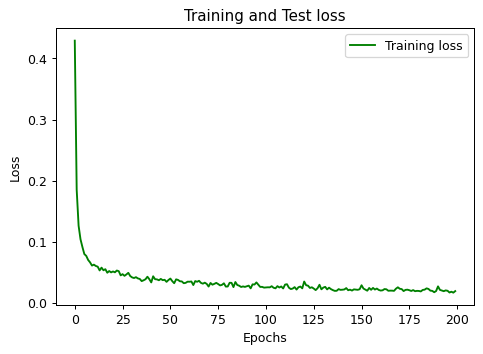

In [27]:
# Plot Training and Test loss
plt.plot(epochs_array, train_loss_array, 'g', label='Training loss')
# plt.plot(epochs_array, test_loss_array, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Infer**

In [28]:
# from torch.jit import load
# model = UNet()
# optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

# checkpoint = torch.load(pretrained_path)

In [29]:
# optimizer.load_state_dict(checkpoint['optimizer'])

In [30]:
# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in checkpoint['model'].items():
#     name = k[7:] # remove `module.`
#     new_state_dict[name] = v
# # load params
# model.load_state_dict(new_state_dict)

**Visualize results**

In [31]:
color_dict= {0: (0, 0, 0),
             1: (255, 0, 0),
             2: (0, 255, 0)}
def mask_to_rgb(mask, color_dict):
    output = np.zeros((mask.shape[0], mask.shape[1], 3))

    for k in color_dict.keys():
        output[mask==k] = color_dict[k]

    return np.uint8(output)  

In [32]:
for  (data, label) in (valid_dataloader):
    img = data
    mask = label
    break
mask = mask.squeeze(dim=1).long()

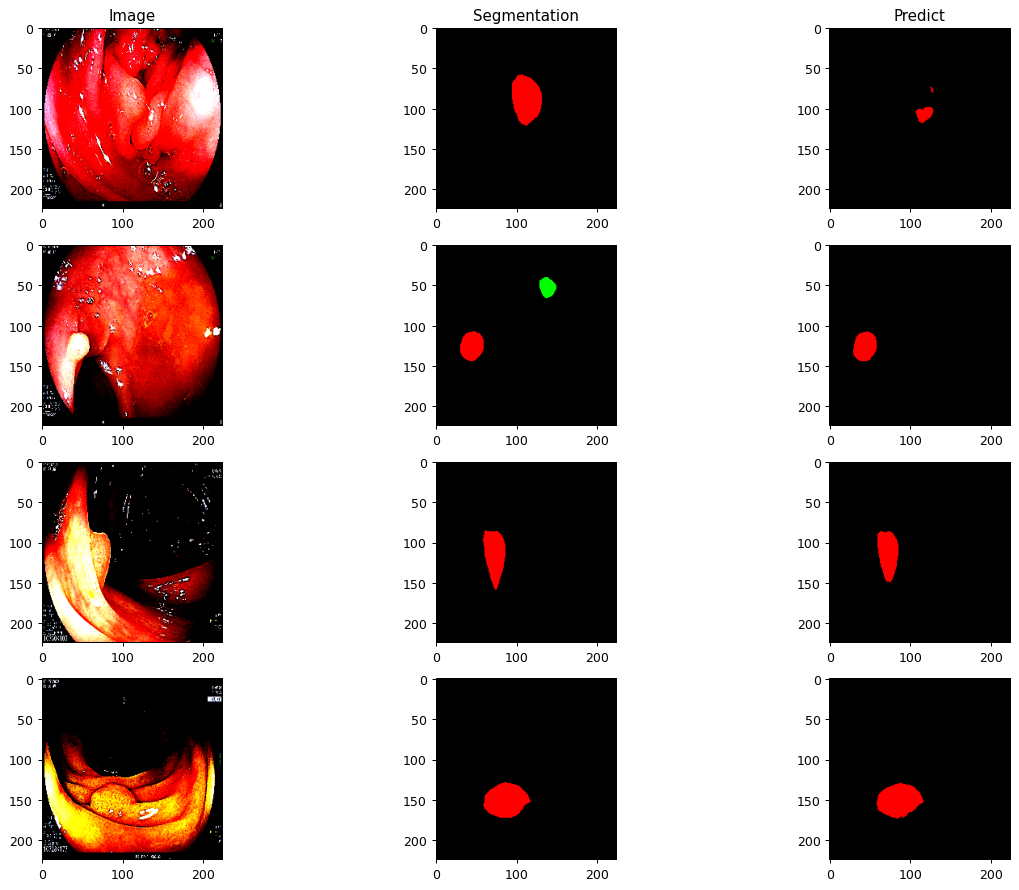

In [33]:
fig, arr = plt.subplots(4, 3, figsize=(16, 12))
arr[0][0].set_title('Image')
arr[0][1].set_title('Segmentation')
arr[0][2].set_title('Predict')

model.eval()
with torch.no_grad():
    predict = model(img)

for i in range(4):
    predict[i] = torch.nn.functional.softmax(predict[i], dim=0)  # Apply softmax
    predict_np = predict[i].cpu().numpy()  # Convert to NumPy array
    np_mask = mask[i].cpu().numpy()
    mask_rgb = mask_to_rgb(np_mask, color_dict) 
    predict_argmax = np.argmax(predict_np, axis=0)
    predict_rgb = mask_to_rgb(predict_argmax, color_dict)
    
    arr[i][0].imshow(img[i].permute(1, 2, 0))
    arr[i][1].imshow(mask_rgb)
    arr[i][2].imshow(predict_rgb)


**Create submission**

In [37]:
testsize = 224
model.eval()
for i in os.listdir("/kaggle/input/bkai-igh-neopolyp/test/test"):
    img_path = os.path.join("/kaggle/input/bkai-igh-neopolyp/test/test", i)
    ori_img = cv2.imread(img_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ori_w = ori_img.shape[0]
    ori_h = ori_img.shape[1]
    img = cv2.resize(ori_img, (testsize, testsize))
    transformed = val_transform(image=img)
    input_img = transformed["image"]
    input_img = input_img.unsqueeze(0).to(device)
    with torch.no_grad():
        output_mask = model.forward(input_img).squeeze(0).cpu().numpy().transpose(1,2,0)
    mask = cv2.resize(output_mask, (ori_h, ori_w))
    mask = np.argmax(mask, axis=2)
    mask_rgb = mask_to_rgb(mask, color_dict)
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite("predicted_masks/{}".format(i), mask_rgb) 

In [39]:
if not os.path.isdir("/kaggle/working/predicted_masks"):
    os.mkdir("/kaggle/working/predicted_masks")

In [40]:
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 225] = 255
    pixels[pixels <= 225] = 0
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r



MASK_DIR_PATH = '/kaggle/working/predicted_masks' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']
df.to_csv(r'output.csv', index=False)

/kaggle/working/predicted_masks/1c0e9082ea2c193ac8d551c149b60f29.jpeg
/kaggle/working/predicted_masks/e19769fa2d37d32780fd497e1c0e9082.jpeg
/kaggle/working/predicted_masks/0626ab4ec3d46e602b296cc5cfd263f1.jpeg
/kaggle/working/predicted_masks/ff05dec1eb3a70b145a7d8d3b6c0ed75.jpeg
/kaggle/working/predicted_masks/7ad1cf2eb9d32a3dc907950289e976c7.jpeg
/kaggle/working/predicted_masks/02fa602bb3c7abacdbd7e6afd56ea7bc.jpeg
/kaggle/working/predicted_masks/eecd70ebce6347c491b37c8c2e5a64a8.jpeg
/kaggle/working/predicted_masks/461c2a337948a41964c1d4f50a5f3601.jpeg
/kaggle/working/predicted_masks/e4a17af18f72c8e6166a915669c99390.jpeg
/kaggle/working/predicted_masks/5664c1711b62f15ec83b97bb11e8e0c4.jpeg
/kaggle/working/predicted_masks/f8e26031fbb5e52c41545ba55aadaa77.jpeg
/kaggle/working/predicted_masks/d077bad31c8c5f54ffaa27a623511c38.jpeg
/kaggle/working/predicted_masks/dd78294679c9cbb2a365b5574868eb60.jpeg
/kaggle/working/predicted_masks/e1797c77826f9a7021bab9fc73303988.jpeg
/kaggle/working/pred